In [ ]:
#!brew install libportaudio2
#!pip install sounddevice

In [1]:
import os
import numpy as np
import pylab as plt
import scipy.signal as sg
import sounddevice as sd
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier


from time import sleep

from IPython.display import Audio, display
def play(x, fs):
    display(Audio(x, rate=fs))
    
from sklearn.model_selection import train_test_split

# load data
data_dir = './'
x_global_train = np.load(os.path.join(data_dir, 'train.npz'))['x']
y_global_train = np.load(os.path.join(data_dir, 'train.npz'))['y']
x_global_test  = np.load(os.path.join(data_dir, 'test.npz'))['x']

# split train dataset into local train and test
x_train, x_test, y_train, y_test = train_test_split(x_global_train, y_global_train, shuffle=True)
fs = 16000

print(x_test.shape, y_test.shape, x_global_test.shape)

(563, 16000) (563,) (750, 16000)


In [2]:
# play a few samples
for k in np.random.choice(np.arange(len(x_train)), 3):
    print(int(y_train[k]))
    play(x_train[k], fs)
    sleep(1.2)

3


2


3


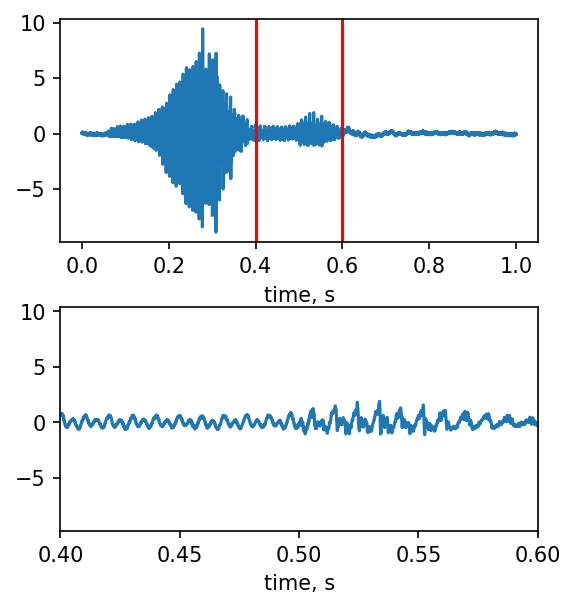

In [3]:
# plot some sample
fig, ax = plt.subplots(2, figsize=(4,4), dpi=150)
plt.tight_layout()

x = x_train[y_train==1][0]

time = np.arange(len(x))/fs

segment = [0.4, 0.6]
ax[0].plot(time, x)
ax[0].set_xlabel('time, s')
[ax[0].axvline(b, color='r') for b in segment]
ax[1].plot(time, x)
ax[1].set_xlim(segment)
ax[1].set_xlabel('time, s')
play(x, fs)

(129,) (1687, 129)


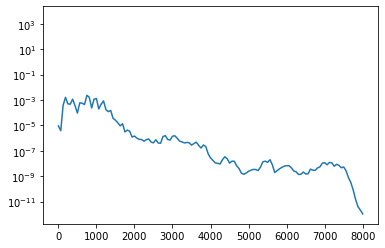

In [4]:
# plot a spectrum of some sample
freq, x_spec_train = sg.welch(x_train, fs, axis=1, )
print(freq.shape, x_spec_train.shape)
plt.plot(freq, x_spec_train[y_train==1][1])
plt.semilogy(0, 4000)

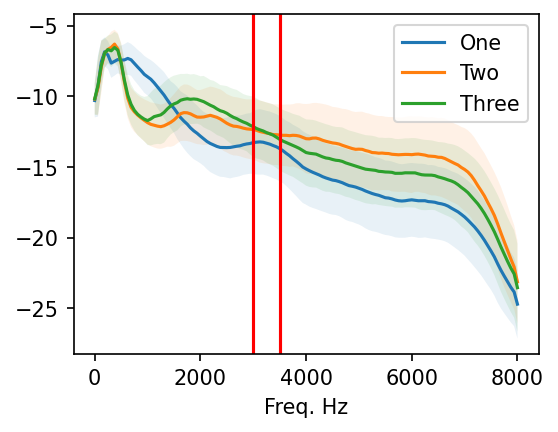

In [5]:
# average spectums for each class
fig, ax = plt.subplots(1, figsize=(4,3), dpi=150)
for k in range(1, 3+1):
    specs = np.log(x_spec_train[y_train==k])
    plt.plot(freq, specs.mean(0), label=['One', 'Two', 'Three'][k-1])
    plt.fill_between(freq, specs.mean(0)-specs.std(0), specs.mean(0)+specs.std(0), alpha=0.1)
    
plt.legend()
plt.xlabel('Freq. Hz')
band = (3000, 3500)
[plt.axvline(b, color='r') for b in band]

In [9]:
def get_accuracy(classifier, f_train, f_test, f_global_test, save=False):
    # collect predictions
    y_train_pred = classifier.predict(f_train).astype(int)
    y_test_pred = classifier.predict(f_test).astype(int)
    y_global_test_pred = classifier.predict(f_global_test).astype(int)
    # save test data predictions
    if save:
        df = pd.DataFrame(data=y_global_test_pred, columns=['Category'])
        df.to_csv('results.csv', index_label='Id')
    return accuracy_score(y_train , y_train_pred), accuracy_score(y_test, y_test_pred)

In [76]:
# define features transformer
def extract_features(x):
    freq, spec = sg.welch(x, fs, axis=1)
    band1 = (1800, 2400)
    band2 = (4500, 5000)
    band3 = (700, 1100)
    band4 = (7000, 7400)
    band5 = (200, 500)
    band6 = (3000, 3500)
    band7 = (7700, 7800)
    band8 = (5000, 6000)
    feature1 = spec[:, (freq>band1[0]) & (freq<band1[1])].mean(1)
    feature2 = spec[:, (freq>band2[0]) & (freq<band2[1])].mean(1)
    feature3 = spec[:, (freq>band3[0]) & (freq<band3[1])].mean(1)
    feature4 = spec[:, (freq>band4[0]) & (freq<band4[1])].mean(1)
    feature5 = spec[:, (freq>band5[0]) & (freq<band5[1])].mean(1)
    feature6 = spec[:, (freq>band6[0]) & (freq<band6[1])].mean(1)
    feature7 = spec[:, (freq>band7[0]) & (freq<band7[1])].mean(1)
    feature8 = spec[:, (freq>band8[0]) & (freq<band8[1])].mean(1)
    data = {
        'band1': feature1,
        'band2': feature2,
        'band3': feature3,
        'band4': feature4,
        'band5': feature5,
        'band6': feature6,
        'band7': feature7,
        'band8': feature8,
    }
    features = pd.DataFrame(data=data)
    return features

In [77]:
# extract features
f_train = extract_features(x_train)
f_test  = extract_features(x_test)
f_global_test = extract_features(x_global_test)

In [82]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(random_state=42, iterations=500, learning_rate=0.1, max_depth=3, verbose=False)
cbc.fit(f_train, y_train)

print(get_accuracy(cbc, f_train, f_test, f_global_test, save=True))

(0.9045643153526971, 0.8188277087033747)


In [79]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(verbose=False)
cbc.fit(f_train, y_train)

print(get_accuracy(cbc, f_train, f_test, f_global_test))

(1.0, 0.8099467140319716)


In [ ]:
"""
# save test data predictions

df = pd.DataFrame(data=y_global_test_pred, columns=['Category'])
df.to_csv('results.csv', index_label='Id')
df = pd.DataFrame(data=y_global_test_pred*0 + 1, columns=['Category'])
df.to_csv('all_one_results.csv', index_label='Id')
""""""